**<p align = center><font color = 99ffff size = 10>Flight Delay Prediction</font></p>**

## **Importing all the necessary libraries**

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark import SparkContext
sc=SparkContext()
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import udf
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from mpl_toolkits.basemap import Basemap 
from pyspark.mllib.classification import LogisticRegressionWithSGD, SVMWithSGD, LogisticRegressionWithLBFGS
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

22/04/20 21:21:29 WARN Utils: Your hostname, NOTATOY resolves to a loopback address: 127.0.1.1; using 172.24.27.83 instead (on interface eth0)
22/04/20 21:21:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/20 21:21:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# **Converting dataset to Resilient Distributed Database (RDD)**

## **Create DataFrame in pyspark from pandas dataframe**  

In [2]:
sqlContext = SQLContext(sc)
pd_df = pd.read_csv('DelayedFlights.csv')
schema = StructType([
    StructField('Year', IntegerType(), True),
    StructField('Month', IntegerType(), True),
    StructField('DayofMonth', IntegerType(), True),
    StructField('DayofWeek', IntegerType(), True),
    StructField('DepTime', IntegerType(), True),
    StructField('CRSDepTime', IntegerType(), True),
    StructField('ArrTime', FloatType(), True),
    StructField('CRSArrTime', IntegerType(), True),
    StructField('UniqueCarrier', StringType(), True),
    StructField('DepDelay', IntegerType(), True),
    StructField('Origin', StringType(), True),
    StructField('Dest', StringType(), True),
    StructField('Distance', IntegerType(), True),
    StructField('CarrierDelay', FloatType(), True),
    StructField('WeatherDelay', FloatType(), True),
    StructField('NASDelay', FloatType(), True),
    StructField('SecurityDelay', FloatType(), True),
    StructField('LateAircraftDelay', FloatType(), True),
    ])
airline_df = sqlContext.createDataFrame(pd_df, schema)

## **Visualizing the dataset**

In [3]:
temp = airline_df.toPandas()
temp = temp.dropna()
temp.head()

22/04/20 21:21:57 WARN TaskSetManager: Stage 0 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.


,Year,Month,DayofMonth,DayofWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,DepDelay,Origin,Dest,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
3,2008,1,3,4,1829,1755,1959.0,1925,WN,34,IND,BWI,515,2.0,0.0,0.0,0.0,32.0
5,2008,1,3,4,1937,1830,2037.0,1940,WN,67,IND,LAS,1591,10.0,0.0,0.0,0.0,47.0
7,2008,1,3,4,1644,1510,1845.0,1725,WN,94,IND,MCO,828,8.0,0.0,0.0,0.0,72.0
9,2008,1,3,4,1452,1425,1640.0,1625,WN,27,IND,PHX,1489,3.0,0.0,0.0,0.0,12.0
11,2008,1,3,4,1323,1255,1526.0,1510,WN,28,IND,TPA,838,0.0,0.0,0.0,0.0,16.0


## **Knowing our attributes/columns**

In [4]:
#printing the columns names
for col in airline_df.columns:
    print(col)

Year
Month
DayofMonth
DayofWeek
DepTime
CRSDepTime
ArrTime
CRSArrTime
UniqueCarrier
DepDelay
Origin
Dest
Distance
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay


## **Adding a new binary attribute to our data frame called `DepDelayed`:**

We've appended a new column in our dataset which will contain the information/label about whether a flight is delayed or not based on the following limit:

True, for flights that have > 28 minutes of delay False, for flights that have <= 28 minutes of delay

In [5]:
# dropping incomplete rows
airline_df=airline_df.dropna()
airline_df = airline_df.withColumn('DepDelayed', (airline_df['DepDelay']>28))

In [6]:
# define hour function to obtain hour of day
def hour_ex(x): 
    h = int(str(int(x)).zfill(4)[:2])
    return h

# register as a UDF 
f = udf(hour_ex, IntegerType())

#CRSDepTime: scheduled departure time (local, hhmm)
airline_df = airline_df.withColumn('hour', f(airline_df.CRSDepTime))
#used to register the dataframe df as a temporary table airports so that we are able to query the table.
airline_df.registerTempTable("airlineDF")

# **Performing some data exploration:**



## **Primary reason of delay**

Here we try to find out or explore the possible primary reasons for flight delays.

In [7]:
cause_delay = sqlContext.sql("SELECT sum(WeatherDelay) Weather,sum(NASDelay) NAS,sum(SecurityDelay) Security,sum(LateAircraftDelay) lateAircraft,sum(CarrierDelay) Carrier FROM airlineDF ")

In [8]:
df_cause_delay = cause_delay.toPandas()

22/04/20 21:22:15 WARN TaskSetManager: Stage 1 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.


In [9]:
df_cause_delay.head()

,Weather,NAS,Security,lateAircraft,Carrier
0,2446721.0,9894880.0,63968.0,17372598.0,12940047.0


The above table shows the individual contribution of an attribute for delaying a flight.

The delay due to "ripple delay effect" aka `lateAircarft` is maximum.

## **Let's explore Which airports have the Most Delays?**

In [10]:
#conFlight is 
groupedDelay = sqlContext.sql("SELECT Origin, count(*) conFlight,avg(DepDelay) delay FROM airlineDF GROUP BY Origin")
df_origin = groupedDelay.toPandas()

22/04/20 21:22:18 WARN TaskSetManager: Stage 4 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.


In [11]:
df_origin.sort_values('delay',ascending=0).head()

,Origin,conFlight,delay
270,CMX,16,200.250000
211,ACY,11,184.363636
276,PLN,10,125.500000
280,MOT,49,108.959184
274,BPT,6,103.666667


### **Load the airport_location dataset**

Mapping each Airport to their corresponding Long and Lat.

In [12]:
airport_loc_df = pd.read_csv('airport_location.csv',index_col=0, names = ['name', 'city', 'country','faa_code','ICAO','lat','lng','alt','TZone','DST','Tz'], header=0)
airport_loc_df.head()

,name,city,country,faa_code,ICAO,lat,lng,alt,TZone,DST,Tz
2,Madang,Madang,Papua New Guinea,MAG,AYMD,-5.207083,145.788700,20,10.0,U,Pacific/Port_Moresby
3,Mount Hagen,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826789,144.295861,5388,10.0,U,Pacific/Port_Moresby
4,Nadzab,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569828,146.726242,239,10.0,U,Pacific/Port_Moresby
5,Port Moresby Jacksons Intl,Port Moresby,Papua New Guinea,POM,AYPY,-9.443383,147.220050,146,10.0,U,Pacific/Port_Moresby
6,Wewak Intl,Wewak,Papua New Guinea,WWK,AYWK,-3.583828,143.669186,19,10.0,U,Pacific/Port_Moresby


In [13]:
#merging both datasets' dataframes into one
df_airports = pd.merge(df_origin,airport_loc_df,left_on = 'Origin',right_on = 'faa_code')
df_airports.head()

,Origin,conFlight,delay,name,city,country,faa_code,ICAO,lat,lng,alt,TZone,DST,Tz
0,MSY,3713,57.008080,Louis Armstrong New Orleans Intl,New Orleans,United States,MSY,KMSY,29.993389,-90.258028,4,-6.0,A,America/Chicago
1,GEG,1084,55.563653,Spokane Intl,Spokane,United States,GEG,KGEG,47.619861,-117.533833,2376,-8.0,A,America/Los_Angeles
2,SNA,3441,53.254868,John Wayne Arpt Orange Co,Santa Ana,United States,SNA,KSNA,33.675667,-117.868222,56,-8.0,A,America/Los_Angeles
3,BUR,2377,51.273875,Bob Hope,Burbank,United States,BUR,KBUR,34.200667,-118.358667,778,-8.0,A,America/Los_Angeles
4,GRB,855,73.169591,Austin Straubel Intl,Green Bay,United States,GRB,KGRB,44.485072,-88.129589,695,-6.0,A,America/Chicago


In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def zscore(x):
    return (x-np.average(x))/np.std(x)

### **Plotting on the Map**

Threshold for number of flights from particular origin is set as greater than 15000.

Each marker is an airport.
Size of markers: Airport Traffic (larger means higher number of flights in year)
Color of markers: Average Flight Delay (Redder means longer delays)


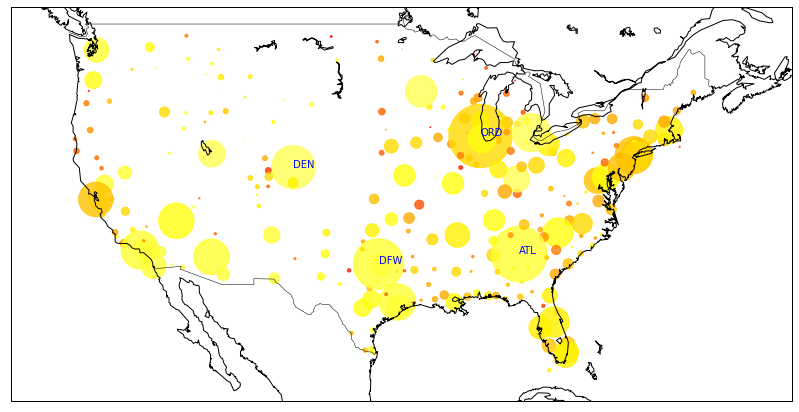

In [15]:
rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 30))
colors=np.flipud(colors)

#----- Scatter -------
countrange=max(df_airports['conFlight'])-min(df_airports['conFlight'])
al=np.array([sigmoid(x) for x in zscore(df_airports['delay'])])
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
val=df_airports['conFlight']*4000.0/countrange

my_map.scatter(xs, ys,  marker='o', s= val, alpha = 0.8,color=colors[(al*20).astype(int)])

#----- Text -------
df_text=df_airports[(df_airports['conFlight']>20000) & (df_airports['faa_code'] != 'HNL')]
xt,yt = my_map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))
txt=np.asarray(df_text['faa_code'])
zp=zip(xt,yt,txt)
for row in zp:
   
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue')

print("Each marker is an airport.")
print("Size of markers: Airport Traffic (larger means higher number of flights in year)")
print("Color of markers: Average Flight Delay (Redder means longer delays)")

plt.show()

## **Now let's explore which Routes are typically the most delayed?**

In [16]:
grp_rout_Delay = sqlContext.sql("SELECT Origin, Dest, count(*) traffic,avg(Distance) avgDist, avg(DepDelay) avgDelay FROM airlineDF GROUP BY Origin,Dest")
rout_Delay = grp_rout_Delay.toPandas()

22/04/20 21:22:25 WARN TaskSetManager: Stage 7 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.


In [17]:
df_airport_rout1 = pd.merge(rout_Delay, airport_loc_df, left_on = 'Origin', right_on = 'faa_code')
df_airport_rout2 = pd.merge(df_airport_rout1, airport_loc_df, left_on = 'Dest', right_on = 'faa_code')
df_airport_rout = df_airport_rout2[["Origin","lat_x","lng_x","Dest","lat_y","lng_y", "avgDelay", "traffic"]]

In [18]:
df_airport_rout.sort_values('avgDelay',ascending=0).head()

,Origin,lat_x,lng_x,Dest,lat_y,lng_y,avgDelay,traffic
812,SBN,41.708661,-86.317250,CVG,39.048836,-84.667822,518.000000,1
1511,MBS,43.532913,-84.079647,MSP,44.881956,-93.221767,368.000000,1
1835,EGE,39.642556,-106.917694,MIA,25.793250,-80.290556,289.555556,9
3971,HDN,40.481181,-107.217660,LGA,40.777245,-73.872608,258.000000,1
1328,BMI,40.477111,-88.915917,LAS,36.080056,-115.152250,239.000000,1


### **Plotting on the map:**
The more intense delayed routes are visualized or represented by the intensity of the **<font color = 'red'> RED </font>** colour. 


Each line represents a route from the Origin to Destination airport.
The redder line, the higher probablity of delay.


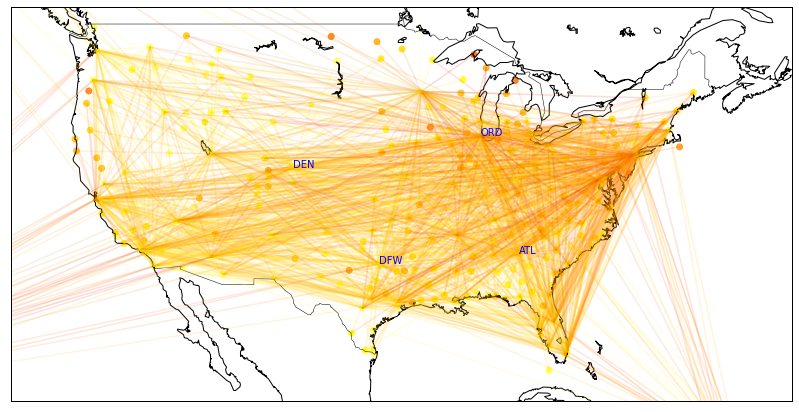

In [19]:
rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

delay=np.array([sigmoid(x) for x in zscore(df_airports["delay"])])
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 40))
colors=np.flipud(colors)
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
xo,yo = my_map(np.asarray(df_airport_rout['lng_x']), np.asarray(df_airport_rout['lat_x']))
xd,yd = my_map(np.asarray(df_airport_rout['lng_y']), np.asarray(df_airport_rout['lat_y']))

my_map.scatter(xs, ys,  marker='o',  alpha = 0.8,color=colors[(delay*20).astype(int)])


al=np.array([sigmoid(x) for x in zscore(df_airport_rout["avgDelay"])])
f=zip(xo,yo,xd,yd,df_airport_rout['avgDelay'],al)
for row in f:
    plt.plot([row[0],row[2]], [row[1],row[3]],'-',alpha=0.07, color=colors[(row[5]*30).astype(int)] )
xt,yt = my_map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))    
txt=np.asarray(df_text['faa_code'])    
zp=zip(xt,yt,txt)
for row in zp:
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each line represents a route from the Origin to Destination airport.")
print("The redder line, the higher probablity of delay.")
    
plt.show()

## **Let's Explore about a particular airport origin delay per month**

Here we select Chicago O'Hare International Airport codenamed as "ORD" as that particular airport for our origin.

In [20]:
# Considering Illinois O'Hare International Airport because it has most flights origin otherwise the RDD will run out of RAM while training
Origin_Airport="ORD"

In [21]:
df_ORG = sqlContext.sql("SELECT * from airlineDF WHERE origin='"+Origin_Airport+"'")
df_ORG.registerTempTable("df_ORG")
df_ORG.select('ArrTime','CRSArrTime','CRSDepTime', 'DayOfWeek','DayofMonth','DepDelay','DepTime','Dest').show(5)

22/04/20 21:22:36 WARN TaskSetManager: Stage 10 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.


+-------+----------+----------+---------+----------+--------+-------+----+
|ArrTime|CRSArrTime|CRSDepTime|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|
+-------+----------+----------+---------+----------+--------+-------+----+
| 2031.0|      1945|      1600|        2|         8|      71|   1711| EWR|
| 2040.0|      2004|      1742|        5|        25|      31|   1813| CLE|
| 1751.0|      1620|      1240|        1|        28|      78|   1358| EWR|
| 1658.0|      1620|      1240|        5|        25|      50|   1330| EWR|
| 2021.0|      1930|      1600|        2|         1|      52|   1652| EWR|
+-------+----------+----------+---------+----------+--------+-------+----+
only showing top 5 rows



In [22]:
print("total flights from "+ Origin_Airport+" airport: " + str(df_ORG.count()))

22/04/20 21:22:36 WARN TaskSetManager: Stage 11 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.


total flights from ORD airport: 53430


### **Each carrier delay from a ORD airport in different months.**

In [23]:
grp_carr = sqlContext.sql("SELECT UniqueCarrier,month, avg(DepDelay) avgDelay from df_ORG WHERE DepDelayed=True GROUP BY UniqueCarrier,month")
s = grp_carr.toPandas()
s.head()

22/04/20 21:22:38 WARN TaskSetManager: Stage 14 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.


,UniqueCarrier,month,avgDelay
0,UA,1,85.516414
1,XE,1,94.454545
2,YV,1,102.521936
3,OO,1,92.879781
4,NW,1,71.075472


In [24]:
# ps = s.pivot(index='month', columns='UniqueCarrier', values='avgDelay')[['AA','UA','US']]
ps = s.pivot(index='month', columns='UniqueCarrier', values='avgDelay')

Text(0.5, 1.0, 'How much delay does each carrier has in each month?')

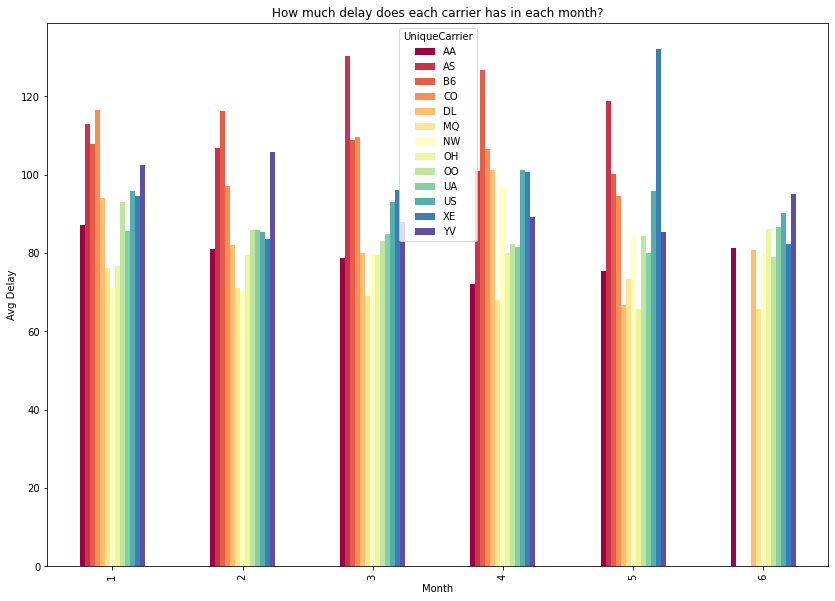

In [25]:
ps.plot(kind='bar', colormap='Spectral')
plt.xlabel('Month')
plt.ylabel('Avg Delay')
plt.title('How much delay does each carrier has in each month?')

### **PLOT INFERENCE**

June have max avg. delay for unique carriera , May have higher avg delay for **XE** carrier.

## **Exploring the airport origin delay per day/hour**

In [26]:
hour_grouped = df_ORG.filter(df_ORG['DepDelayed']).select('DayOfWeek','hour','DepDelay').groupby('DayOfWeek','hour').mean('DepDelay')
hour_grouped.head()


22/04/20 21:22:41 WARN TaskSetManager: Stage 17 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.


Row(DayOfWeek=3, hour=22, avg(DepDelay)=58.875)

Plotting the average delay per hour

22/04/20 21:22:44 WARN TaskSetManager: Stage 20 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.


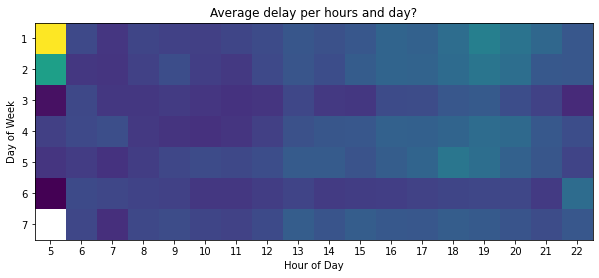

In [27]:
rcParams['figure.figsize'] = (10,5)
dh = hour_grouped.toPandas()
c = dh.pivot('DayOfWeek','hour')
X = c.columns.levels[1].values
Y = c.index.values
Z = c.values
plt.xticks(range(0,len(X)), X)
plt.yticks(range(0,len(Y)), Y)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Average delay per hours and day?')
plt.imshow(Z)

### **PLOT INFERENCE**

Mornings in first days of week possibly because of more business meetings

# **MODELS**

Now we train differenet models on the data and compare their performance. 

Here we used 3 models namely:

1. Logistic Regression with SGD
2. Logistic Regression with LBFGS
3. SVM with SGD 

## **LOGISTIC REGRESSION WITH SGD**

In [28]:
# Feature selection
df_model=df_ORG
stringIndexer1 = StringIndexer(inputCol="Origin", outputCol="originIndex")
model_stringIndexer = stringIndexer1.fit(df_model)
indexedOrigin = model_stringIndexer.transform(df_model)

encoder = OneHotEncoder(dropLast=False,inputCol="originIndex",outputCol="originVec")
encoder= encoder.fit(indexedOrigin)
df_model = encoder.transform(indexedOrigin)

22/04/20 21:22:46 WARN TaskSetManager: Stage 23 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.


In [29]:
assembler = VectorAssembler(
    inputCols = ['Year','Month','DayofMonth','DayofWeek','hour','Distance','originVec'],
    outputCol = "features")
output = assembler.transform(df_model)
airlineRDD=output.rdd.map(lambda row: LabeledPoint([0,1][row['DepDelayed']],row['features'].toArray()))

In [30]:
#  Spliting dataset into train and test dtasets
trainRDD,testRDD=airlineRDD.randomSplit([0.8,0.2])
print(output)

DataFrame[Year: int, Month: int, DayofMonth: int, DayofWeek: int, DepTime: int, CRSDepTime: int, ArrTime: float, CRSArrTime: int, UniqueCarrier: string, DepDelay: int, Origin: string, Dest: string, Distance: int, CarrierDelay: float, WeatherDelay: float, NASDelay: float, SecurityDelay: float, LateAircraftDelay: float, DepDelayed: boolean, hour: int, originIndex: double, originVec: vector, features: vector]


In [31]:
# training the model
model = LogisticRegressionWithSGD.train(trainRDD)

22/04/20 21:22:49 WARN TaskSetManager: Stage 26 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.
22/04/20 21:22:51 WARN TaskSetManager: Stage 27 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.
22/04/20 21:22:51 WARN TaskSetManager: Stage 28 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.
22/04/20 21:22:53 WARN TaskSetManager: Stage 29 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.
22/04/20 21:22:56 WARN TaskSetManager: Stage 30 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.
22/04/20 21:22:57 WARN TaskSetManager: Stage 31 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.
22/04/20 21:22:57 WARN TaskSetManager: Stage 33 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.

In [32]:
# Evaluating the model on testing data
preds = testRDD.map(lambda p: (p.label, model.predict(p.features)))

In [33]:
def conf(r):
    if r[0] == r[1] ==1: x= 'TP'
    if r[0] == r[1] ==0: x= 'TN'
    if r[0] == 1 and  r[1] ==0: x= 'FN'
    if r[0] == 0 and  r[1] ==1: x= 'FP'
    return (x)

In [34]:
acc1 = preds.map(lambda vp: ((vp[0], vp[1]),1)).reduceByKey(lambda a, b: a + b).take(5)
acc = [(conf(x[0]),x[1]) for x in acc1]

22/04/20 21:23:17 WARN TaskSetManager: Stage 233 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.


In [35]:
TP=TN=FP=FN=0.0
for x in acc: 
    if x[0]=='TP': TP= x[1]
    if x[0]=='TN': TN= x[1]
    if x[0]=='FP': FP= x[1]
    if x[0]=='FN': FN= x[1]
    
eps = sys.float_info.epsilon
Accuracy = (TP+TN) / (TP + TN+ FP+FN+eps) 
precision = TP/(TP+FP+eps)
recall = TP/(TP+FN+eps)
specificity=TN/(FN+TN+eps)
f1_score = 2*((precision*recall)/(precision+recall))
print ("Model Accuracy for "+ Origin_Airport+": %1.2f %%" % (Accuracy*100))
print ("Model Precision for "+ Origin_Airport+": %1.2f %%" % (precision*100))
print ("Model Recall for "+ Origin_Airport+": %1.2f %%" % (recall*100))
print ("Model Specificty for "+ Origin_Airport+": %1.2f %%" % (specificity*100))
print ("Model F1-score for "+ Origin_Airport+": %1.2f %%" % (f1_score*100))

Model Accuracy for ORD: 72.73 %
Model Precision for ORD: 72.73 %
Model Recall for ORD: 100.00 %
Model Specificty for ORD: 0.00 %
Model F1-score for ORD: 84.21 %


## **LOGISTIC REGRESSION WITH LBFGS**

In [36]:
# training the model
model_lr = LogisticRegressionWithLBFGS.train(trainRDD)

22/04/20 21:23:21 WARN TaskSetManager: Stage 239 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.
22/04/20 21:23:21 WARN TaskSetManager: Stage 240 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.
22/04/20 21:23:22 WARN TaskSetManager: Stage 241 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.
22/04/20 21:23:26 WARN Instrumentation: [90010e07] Fitting LogisticRegressionModel without intercept on dataset with constant nonzero column, Spark MLlib outputs zero coefficients for constant nonzero columns. This behavior is the same as R glmnet but different from LIBSVM.
22/04/20 21:23:26 WARN Instrumentation: [90010e07] Initial coefficients will be ignored! Its dimensions (1, 7) did not match the expected size (1, 7)
22/04/20 21:23:26 WARN TaskSetManager: Stage 243 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.

In [37]:
# Evaluating the model on testing data
preds_lr = testRDD.map(lambda p: (p.label, model_lr.predict(p.features)))

In [38]:
acc1_lr = preds_lr.map(lambda vp: ((vp[0], vp[1]),1)).reduceByKey(lambda a, b: a + b).take(5)
acc_lr = [(conf(x[0]),x[1]) for x in acc1_lr]

22/04/20 21:23:30 WARN TaskSetManager: Stage 283 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.


In [39]:
TP=TN=FP=FN=0.0
for x in acc_lr: 
    if x[0]=='TP': TP= x[1]
    if x[0]=='TN': TN= x[1]
    if x[0]=='FP': FP= x[1]
    if x[0]=='FN': FN= x[1]
    
eps_lr = sys.float_info.epsilon
Accuracy_lr = (TP+TN) / (TP + TN+ FP+FN+eps_lr)
precision_lr = TP/(TP+FP+eps_lr)
recall_lr = TP/(TP+FN+eps_lr)
specificity_lr=TN/(FN+TN+eps_lr)
f1_score_lr = 2*((precision_lr*recall_lr)/(precision_lr+recall_lr))
print ("Model Accuracy for "+ Origin_Airport+": %1.2f %%" % (Accuracy_lr*100))
print ("Model Precision for "+ Origin_Airport+": %1.2f %%" % (precision_lr*100))
print ("Model Recall for "+ Origin_Airport+": %1.2f %%" % (recall_lr*100))
print ("Model Specificty for "+ Origin_Airport+": %1.2f %%" % (specificity_lr*100))
print ("Model F1-score for "+ Origin_Airport+": %1.2f %%" % (f1_score_lr*100))

Model Accuracy for ORD: 72.74 %
Model Precision for ORD: 72.75 %
Model Recall for ORD: 99.96 %
Model Specificty for ORD: 57.14 %
Model F1-score for ORD: 84.21 %


## **SVM WITH SGD**

In [40]:
model_svm = SVMWithSGD.train(trainRDD)

22/04/20 21:23:34 WARN TaskSetManager: Stage 289 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.
22/04/20 21:23:34 WARN TaskSetManager: Stage 290 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.
22/04/20 21:23:35 WARN TaskSetManager: Stage 291 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.
22/04/20 21:23:35 WARN TaskSetManager: Stage 292 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.
22/04/20 21:23:38 WARN TaskSetManager: Stage 293 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.
22/04/20 21:23:38 WARN TaskSetManager: Stage 294 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.
22/04/20 21:23:38 WARN TaskSetManager: Stage 296 contains a task of very large size (11281 KiB). The maximum recommended task size is 10

In [41]:
# Evaluating the model on testing data
preds_svm = testRDD.map(lambda p: (p.label, model_svm.predict(p.features)))

In [42]:
acc1_svm = preds_svm.map(lambda vp: ((vp[0], vp[1]),1)).reduceByKey(lambda a, b: a + b).take(5)
acc_svm = [(conf(x[0]),x[1]) for x in acc1_svm]

22/04/20 21:23:54 WARN TaskSetManager: Stage 496 contains a task of very large size (11281 KiB). The maximum recommended task size is 1000 KiB.


In [43]:
TP=TN=FP=FN=0.0
for x in acc_svm: 
    if x[0]=='TP': TP= x[1]
    if x[0]=='TN': TN= x[1]
    if x[0]=='FP': FP= x[1]
    if x[0]=='FN': FN= x[1]
    
eps_svm = sys.float_info.epsilon
Accuracy_svm = (TP+TN) / (TP + TN+ FP+FN+eps_svm) 
precision_svm = TP/(TP+FP+eps_svm)
recall_svm = TP/(TP+FN+eps_svm)
specificity_svm=TN/(FN+TN+eps_svm)
f1_score_svm= 2*((precision_svm*recall_svm)/(precision_svm+recall_svm))
print ("Model Accuracy for "+ Origin_Airport+": %1.2f %%" % (Accuracy_svm*100))
print ("Model Precision for "+ Origin_Airport+": %1.2f %%" % (precision_svm*100))
print ("Model Recall for "+ Origin_Airport+": %1.2f %%" % (recall_svm*100))
print ("Model Specificty for "+ Origin_Airport+": %1.2f %%" % (specificity_svm*100))
print ("Model F1-score for "+ Origin_Airport+": %1.2f %%" % (f1_score_svm*100))

Model Accuracy for ORD: 72.73 %
Model Precision for ORD: 72.73 %
Model Recall for ORD: 100.00 %
Model Specificty for ORD: 0.00 %
Model F1-score for ORD: 84.21 %


## **Comparison of models**

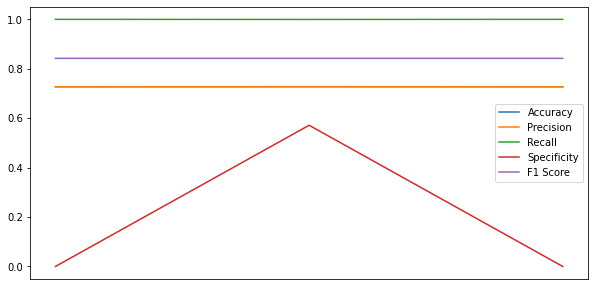

In [44]:
plt.plot([Accuracy, Accuracy_lr, Accuracy_svm])
plt.plot([precision, precision_lr, precision_svm])
plt.plot([recall, recall_lr, recall_svm])
plt.plot([specificity, specificity_lr, specificity_svm])
plt.plot([f1_score, f1_score_lr, f1_score_svm])
plt.legend(['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score'])
plt.tick_params(bottom = False, labelbottom = False)
plt.show()

# **CONCLUSION**

The best accuracy was given by the `Logistic regression with LBFGS` model. The delay predictions were made by keeping one Airport (ORD) as the origin in order to ease out the calculations. The reason for low accuracy can be explained using the above assumption. Since there was ony one origin point under consideration, this lead to decrease in the data available for training and thus the lower accuracy.  

<font color = red>We used only one airport as the origin because when we tried to use every airport as the origin, our system ran out of memory to processing the data because PySpark do In-Memory processing.</font>